### **Price prediction in public procurement**

---

### **Team Members**
<div style="font-family: Arial, sans-serif;">
<table style="width: 50%; margin: auto; border-collapse: collapse; border: 1px solid black;">
  <thead>
    <tr style="background-color: #f2f2f2; border: 1px solid black;">
      <th style="padding: 8px; text-align: left;">Full Name</th>
      <th style="padding: 8px; text-align: left;">ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 8px; text-align: left;">Roman Savoskin</td>
      <td style="padding: 8px; text-align: left;">24MD0378</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">Amina Duisembayeva</td>
      <td style="padding: 8px; text-align: left;">24MD0349</td>
    </tr>
    <tr>
      <td style="padding: 8px; text-align: left;">Dastan Alibekov</td>
      <td style="padding: 8px; text-align: left;">24MD0339</td>
    </tr>
  </tbody>
</table>
</div>

---

### Dataset
We upload all subparts of prepared dataset before filtering, aggregation and joins into [Teams Drive](https://kbtuedu-my.sharepoint.com/:f:/g/personal/rom_savoskin_kbtu_kz/EuX15EEtYyVGlw_kWTj7y70BxXid0uH3v25O_8OhvVNTYg?e=3H6DBP) due to bigger storage size for students  
Our final dataset could be found on [Google Drive](https://drive.google.com/file/d/16FiXTS7I1beJj7HOs6U903eeniAA9iMD/view?usp=drive_link)


### **Source Code**
The source code for this project is hosted on [GitHub](https://github.com/savoskin0502/public-procurement-optimization)


#### **Directory Structure**
- **/migrations/** - includes database migration scripts using `flyway` to prepare database with all required tables and scripts. We found it easier to prepare our initial dataset using SQL rathen than python and `.csv`. `V__` - versioned migrations, execution order matter. `R__` - repeatable migrations, will be executed after `versioned` migrations.
- **/api/src/** - contains the implementation of the API logic using streamlit, including gathering information by lot number from [goszakup](https://goszakup.gov.kz/) and price prediction using `XgBoost` and `Multi Armed Bandits`
- **/.devcontainer/** - config file to deploy our service and make it accessible by dns [https://pricing-kbtu.streamlit.app/](https://pricing-kbtu.streamlit.app/)
- **/parser/** - scripts to extract data from [goszakup](https://goszakup.gov.kz/) using [graphql](https://ows.goszakup.gov.kz/help/v3/schema/query.doc.html) that we will upload further to [Teams Drive](https://kbtuedu-my.sharepoint.com/:f:/g/personal/rom_savoskin_kbtu_kz/EuX15EEtYyVGlw_kWTj7y70BxXid0uH3v25O_8OhvVNTYg?e=3H6DBP)


#### **How to Run**
1. **Setup Environment**:  
   Ensure the required dependencies are installed. Refer to the `README.md` in the root directory for setup instructions.

2. **Run Service**:  
   Navigate to `/src/service/` and execute the command:  
   ```bash
   python main.py


#### **How to Run**
1. **Please, install `Makefile`**

2. **You can run any target you wish from `Makefile`**
    ```bash
    make run-api # will run streamlit API locally
    ```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
import xgboost as xgb
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
import os
import gdown

file_name = "dataset.csv"
file_id = "16FiXTS7I1beJj7HOs6U903eeniAA9iMD"
drive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(file_name):
    print(f"{file_name} does not exist. Downloading...")
    gdown.download(drive_url, file_name, quiet=False)
    print(f"{file_name} has been downloaded successfully.")
else:
    print(f"{file_name} already exists.")

# 1. Data Preprocessing

## Loading the raw dataset

Unnecessary columns were removed after analyzing their composition.

In [ ]:
data = pd.read_csv(
    'dataset_wparticipant_v2.csv',
    delimiter=';',
    dtype=str,
    usecols=[
        "lot_id",
        "fw_total_price_wdiscount",
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount",

        # integers
        "total_count",        
        "ad_lots_count",

        # binary
        "is_union_lots",
        "is_dumping",
        "is_consulting_services",
        "is_disable_person_advertisement",
        "ad_disable_person_id",
        "ad_purchase_type_id",
        "participant_is_have_website",
        "participant_is_quazi",
        "participant_is_national_company",
        "participant_is_association_with_disabilities",
        "participant_is_supplier",
        "participant_is_state_monopoly",
        "participant_is_natural_monopoly",
        "participant_is_small_employer",
        "participant_is_single_org",
        
        # categorical
        "lot_status_id",
        "plan_trade_method_id",
        "psd_sign",
        "single_org_sign",
        "is_light_industry",
        "is_construction_work",
        "ad_trade_method_id",
        "ad_subject_type_id",
        "ad_trade_type_id",
        "ad_single_org_sign",
        "ad_is_light_industry",
        "ad_is_construction_work",
        "participant_creation_date",
        "participant_registration_year",
        "participant_krp_code",
        "participant_oked_list",
        "participant_kse_code",

        # additional
        "ad_start_date",
        "ad_repeat_start_date",
        "ad_end_date",
        "ad_repeat_end_date",
        "ad_publish_date",

        "ad_fin_years",
        "ad_katos",
        "participant_registration_date",
        "participant_kato_list",
        "participant_kopf_code",
        "participant_branches",
        "participant_parent_company",
        
        # 'customer_id',
        # fact_trade_method_id,
        # plans_ids
        # ad_customer_id - не заполнялось
        # advertisement_status_id - оставили только 350, завершенные закупки
        # ad_itogi_date_public - известно только после окончания закупки
        # participant_id
        # participant_bin
        # participant_iin
        # participant_country - только Казахстан
        # participant_is_organizer
        # participant_is_customer
        # participant_is_resident - не особо заполняется
        # participant_supplier_type - особо не заполняется
        # participant_is_world_company - особо не заполняется
        # participant_is_patronymic_producer - везде одно значение
        # participant_is_patronymic_supplier - везде одно
        
    ]
)
data.head()

In [3]:
quantiles = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]

Converting to numeric columns to correct numeric types.

In [4]:
for numeric_field in (
    "fw_total_price_wdiscount",
    "sw_total_price_wdiscount",
    "ad_total_sum",
    "total_amount",

    "total_count",        
    "ad_lots_count",
):
    data[numeric_field] = pd.to_numeric(data[numeric_field])

Status id 360 is indicative of completed lots.

In [5]:
data = data[data.lot_status_id == '360'] # ток состоявшиеся лоты

Removing cells without a second (runner-up) winner, i.e. with only one bidder.

In [6]:
data.loc[data.sw_total_price_wdiscount.isna(), "sw_total_price_wdiscount"] = data.loc[data.sw_total_price_wdiscount.isna(), "total_amount"]

A total of 1,163 rows will be removed due to inaccuracies in the portal data, such as mismatches between the quantity and price per item or the total price.

In [7]:
data = data[~(data.sw_total_price_wdiscount < data.fw_total_price_wdiscount)]

## Analysis of the data: Removing unnecessary and highly-correlated data

Looking at distribution by quantiles.

In [38]:
pd.DataFrame({
    "Quantile": quantiles,
    "fw_total_price_wdiscount": data.fw_total_price_wdiscount.quantile(quantiles)
})

,Quantile,fw_total_price_wdiscount
0.00,0.00,0.00
0.01,0.01,0.00
0.05,0.05,0.00
0.10,0.10,"1,440.00"
0.25,0.25,"9,200.00"
0.50,0.50,"42,000.00"
0.75,0.75,"202,500.00"
0.90,0.90,"1,008,133.20"
0.95,0.95,"3,019,500.00"
0.99,0.99,"24,426,215.00"


Removing lots with 0 or very low total sums, which are in most charity lots.

In [8]:
data = data[~(data.fw_total_price_wdiscount <= data.fw_total_price_wdiscount.quantile(0.10))] # мы не занимаемся благотворительностью

In [50]:
pd.DataFrame({
    "Quantile": quantiles,
    "(total_amount / fw_total_price_wdiscount)": (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)
})

,Quantile,(total_amount / fw_total_price_wdiscount)
0.00,0.00,1.00
0.01,0.01,1.00
0.05,0.05,1.00
0.10,0.10,1.03
0.25,0.25,1.12
0.50,0.50,1.34
0.75,0.75,1.69
0.90,0.90,2.12
0.95,0.95,2.47
0.99,0.99,3.65


A total of ~55,000 rows were removed where the pricing was excessively reduced without justification, as identified by analyzing cases where the ratio of total_amount to fw_total_price_wdiscount exceeded the 99th percentile.

In [10]:
data = data[~((data['total_amount'] / data['fw_total_price_wdiscount']) > (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(0.99))]

In [62]:
len(data[data.fw_total_price_wdiscount == data.total_amount]) / len(data), (data.fw_total_price_wdiscount / data.total_amount).quantile(quantiles)

(0.036202481714487256,
 0.00   0.27
 0.01   0.33
 0.05   0.42
 0.10   0.48
 0.25   0.60
 0.50   0.75
 0.75   0.89
 0.90   0.97
 0.95   1.00
 0.99   1.00
 1.00   1.00
 dtype: float64)

A look-through unearned revenue composition in each quantile.

In [72]:
quantile_values = data['total_amount'].quantile(quantiles)
cumulative_lots = [data['total_amount'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

data['unearned_revenue'] = data['sw_total_price_wdiscount'] - data['fw_total_price_wdiscount']
data['unearned_revenue_pct'] = (data['sw_total_price_wdiscount'] / data['fw_total_price_wdiscount'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0

for start, end in zip(range_start, range_end):
    unearned_sum = data[(data['total_amount'] > start) & (data['total_amount'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = data[(data['total_amount'] > start) & (data['total_amount'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not data[(data['total_amount'] > start) & (data['total_amount'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)

unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct
})

unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent
0.00,0.00,"1,446.40",1,1,0.10,0.10,0.01
0.01,0.01,"2,490.00",51773,51772,"8,372,223.85","8,372,223.95",10.71
0.05,0.05,"4,907.08",258508,206735,"82,637,387.61","91,009,611.56",16.80
0.10,0.10,"8,000.00",527033,268525,"191,759,855.27","282,769,466.83",17.65
0.25,0.25,"22,321.50",1293660,766627,"1,115,449,852.44","1,398,219,319.27",16.16
0.50,0.50,"84,000.00",2589500,1295840,"5,203,651,850.92","6,601,871,170.19",13.82
0.75,0.75,"355,221.24",3877615,1288115,"17,680,904,321.84","24,282,775,492.03",12.00
0.90,0.90,"1,696,428.40",4653145,775530,"40,372,357,850.69","64,655,133,342.72",10.61
0.95,0.95,"4,742,395.20",4911645,258500,"43,174,945,101.28","107,830,078,444.00",9.02
0.99,0.99,"35,614,678.65",5118451,206806,"126,436,485,202.13","234,266,563,646.13",7.35


The correlation between ad_total_sum and total_amount was found to be strong. To reduce multicollinearity, the feature with a lower correlation to the target variable, ad_total_sum, was excluded from the dataset.

In [86]:
data[
    [
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount"
    ]
].corr()

,sw_total_price_wdiscount,ad_total_sum,total_amount
sw_total_price_wdiscount,1.00,0.73,1.00
ad_total_sum,0.73,1.00,0.73
total_amount,1.00,0.73,1.00


Plotting distribution of amounts: sums for the lot, for the ad (consisting of one or several lots) and second winner bidded prices for a lot.

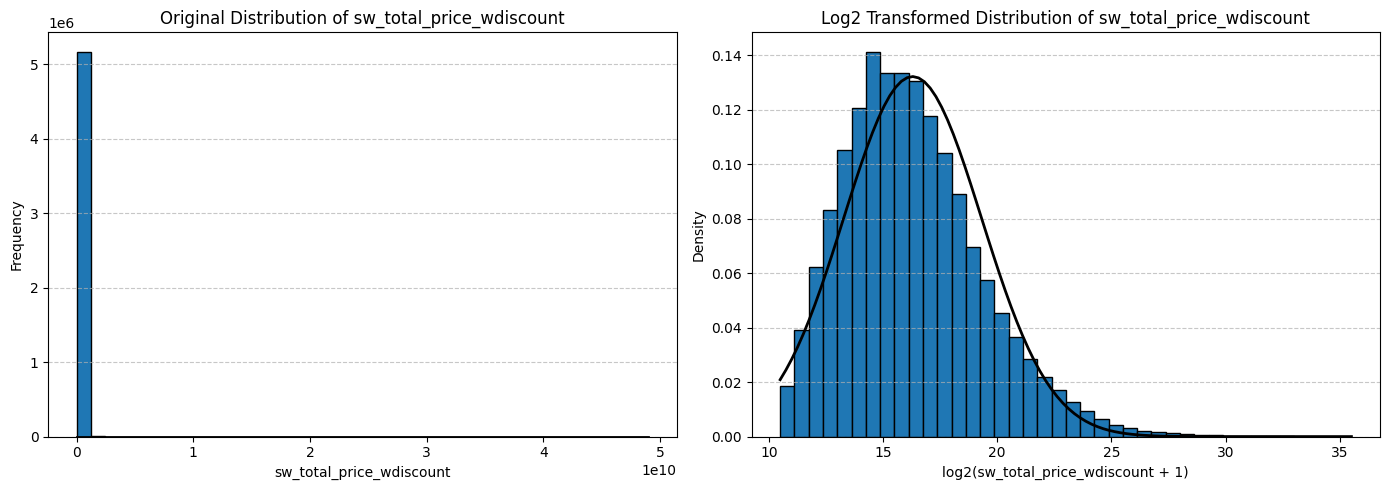

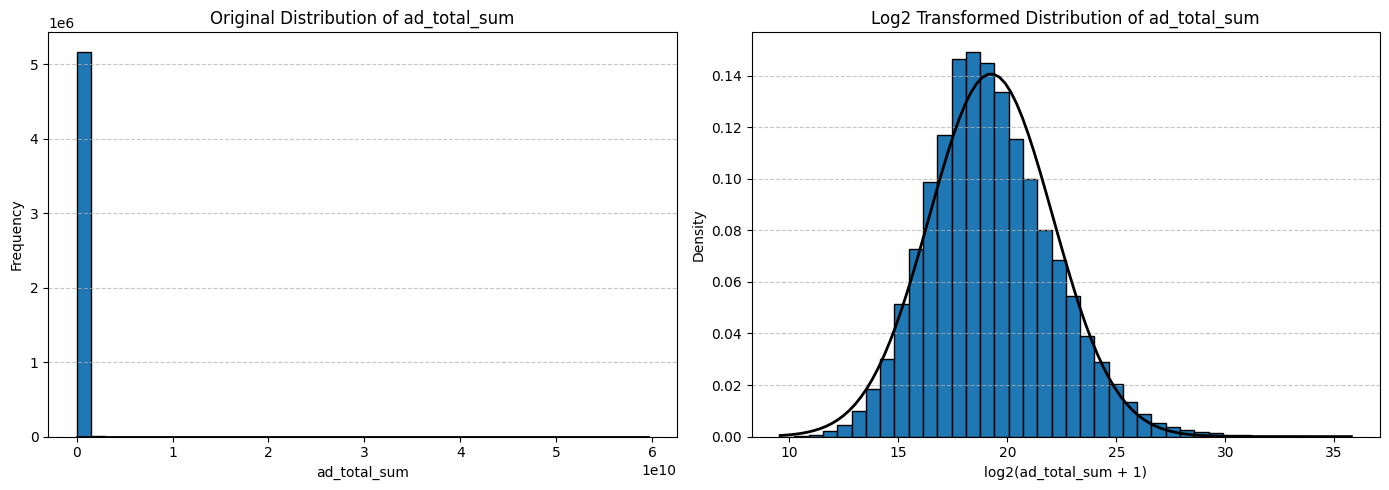

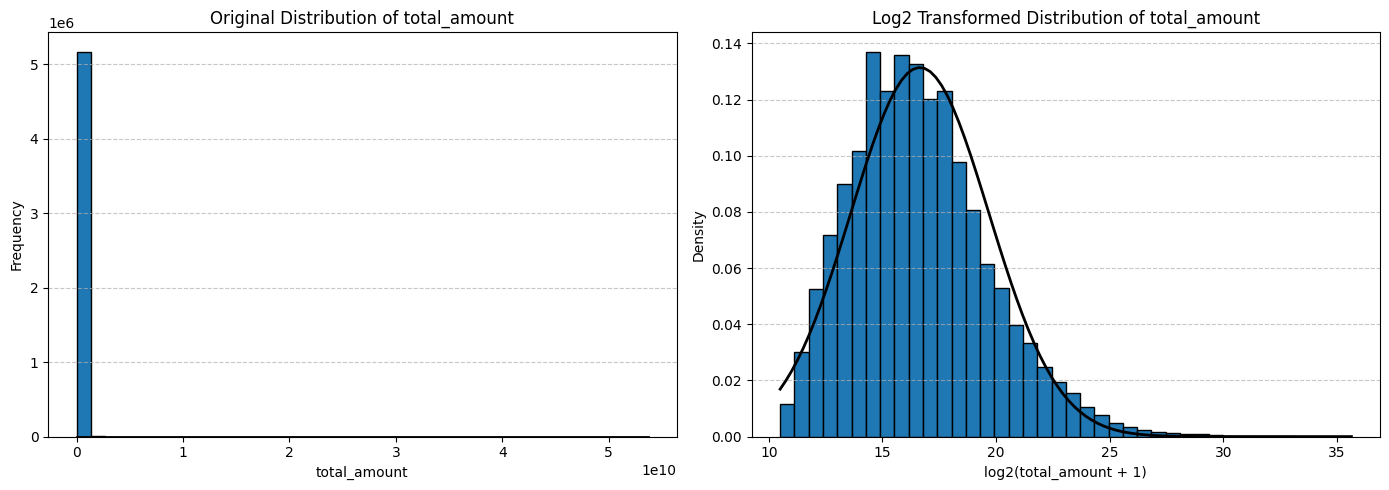

In [90]:
for col in ["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(data[col], bins=40, edgecolor="black")

    mu, std = norm.fit(data[col])
    x = np.linspace(data[col].min(), data[col].max(), 100)
    p = norm.pdf(x, mu, std)
    ax[0].plot(x, p, 'k', linewidth=2)

    ax[0].set_title(f"Original Distribution of {col}")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Frequency")
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
 
    log2_data = np.log2(data[col] + 1)
    ax[1].hist(log2_data, bins=40, edgecolor="black", density=True)
    mu, std = norm.fit(log2_data)
    x = np.linspace(log2_data.min(), log2_data.max(), 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'k', linewidth=2)
    ax[1].set_title(f"Log2 Transformed Distribution of {col}")
    ax[1].set_xlabel(f"log2({col} + 1)")
    ax[1].set_ylabel("Density")
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

Distributing count (of items within a lot) to bins by their value. Converting the column to categorical.

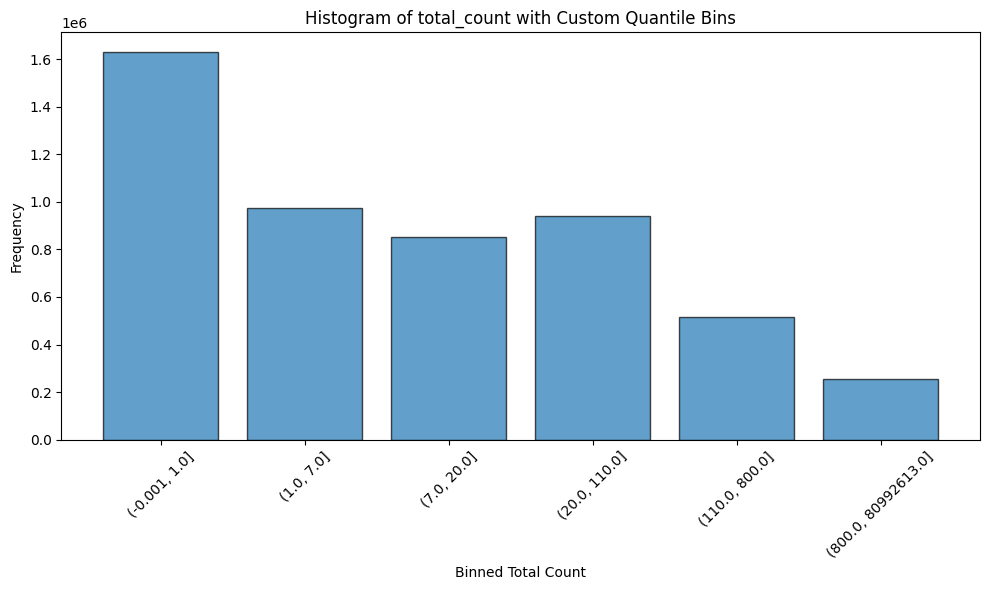

(      Quantile         Bound
 0.00      0.00          0.00
 0.01      0.01          1.00
 0.05      0.05          1.00
 0.10      0.10          1.00
 0.25      0.25          1.00
 0.50      0.50          7.00
 0.75      0.75         50.00
 0.90      0.90        250.00
 0.95      0.95        800.00
 0.99      0.99      6,672.00
 1.00      1.00 80,992,613.00,
            total_count    count
 0        (-0.001, 1.0]  1630561
 1           (1.0, 7.0]   972996
 2          (7.0, 20.0]   852852
 3        (20.0, 110.0]   941965
 4       (110.0, 800.0]   515294
 5  (800.0, 80992613.0]   256485)

In [247]:
quantile_bins = np.unique(data['total_count'].quantile([0.0, 0.05, 0.5, 0.65, 0.85, 0.95, 1]))
bin_counts = pd.cut(data['total_count'], bins=quantile_bins, include_lowest=True).value_counts(sort=False).reset_index()


plt.figure(figsize=(10, 6))
plt.bar(
    bin_counts['total_count'].astype(str), bin_counts['count'], edgecolor='black', alpha=0.7
)
plt.xticks(rotation=45)
plt.title("Histogram of total_count with Custom Quantile Bins")
plt.xlabel("Binned Total Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


pd.DataFrame({
    "Quantile": quantiles,
    "Bound": data['total_count'].quantile(quantiles)
}), bin_counts

In [304]:
data[~data.participant_is_quazi.isna()]

,lot_id,fw_total_price_wdiscount,sw_total_price_wdiscount,lot_status_id,is_union_lots,total_count,total_amount,is_dumping,plan_trade_method_id,psd_sign,...,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_small_employer,participant_is_single_org,unearned_revenue,unearned_revenue_pct,optimal_bin,total_count_quantile,total_count_quantile_bin,total_count_quantile_code
0,29526032,"4,160,393.36","4,186,892.68",360,0,1,"4,907,281.62",1,188,18,...,0,1,0,0,"26,499.32",0.64,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0
1,29525894,"13,900.00","15,900.00",360,0,100,"20,000.00",0,3,0,...,0,1,1,0,"2,000.00",14.39,"(50.0, 250.0]","(50.0, 250.0]","(50.0, 250.0]",3
2,29524214,"209,999.00","249,000.00",360,0,1,"250,000.00",0,3,0,...,0,0,0,0,"39,001.00",18.57,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0
3,29520431,"2,400.00","2,790.00",360,0,30,"3,000.00",0,3,0,...,0,0,0,0,390.00,16.25,"(7.0, 50.0]","(7.0, 50.0]","(7.0, 50.0]",2
4,29415829,"169,000.00","171,600.00",360,0,5,"214,285.70",0,3,0,...,0,0,1,0,"2,600.00",1.54,"(1.0, 7.0]","(1.0, 7.0]","(1.0, 7.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034216,29546364,"21,800.00","28,700.00",360,0,100,"45,000.00",0,3,0,...,0,1,0,0,"6,900.00",31.65,"(50.0, 250.0]","(50.0, 250.0]","(50.0, 250.0]",3
6034217,29538544,"6,960.00","7,000.00",360,0,20,"8,000.00",0,3,0,...,0,0,0,0,40.00,0.57,"(7.0, 50.0]","(7.0, 50.0]","(7.0, 50.0]",2
6034218,29535140,"42,000.00","52,500.00",360,0,1,"62,500.00",0,3,0,...,0,0,0,0,"10,500.00",25.00,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0
6034219,29532943,"2,981.00","3,775.00",360,0,1,"3,900.00",0,3,0,...,0,0,0,0,794.00,26.64,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0


In [29]:
data = data[~data.participant_is_quazi.isna()] # remove 73 rows

group_columns = [
    "is_union_lots",
    "is_dumping",
    "is_consulting_services",
    # "is_disable_person_advertisement",
    "ad_disable_person_id",
    "ad_purchase_type_id",
    "participant_is_have_website",
    "participant_is_quazi",
    "participant_is_national_company",
    "participant_is_association_with_disabilities",
    "participant_is_supplier",
    "participant_is_state_monopoly",
    "participant_is_natural_monopoly",
    "participant_is_small_employer",
    "participant_is_single_org",
]

data[group_columns] = data[group_columns].astype(int)


Analyzing the correlation matrix of categorical features to identify relationships and potential redundancies among them.

In [334]:
grouped_results = []

for col in group_columns:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results.append(temp_df)

combined_data = pd.concat(grouped_results, axis=0, ignore_index=True)
combined_data[['name', 'value', 'count']]

,name,value,count
0,is_union_lots,0,5087666
1,is_union_lots,1,82414
2,is_dumping,0,4936716
3,is_dumping,1,233364
4,is_consulting_services,0,5140100
5,is_consulting_services,1,29980
6,ad_disable_person_id,0,5081985
7,ad_disable_person_id,1,88095
8,ad_purchase_type_id,0,5148143
9,ad_purchase_type_id,1,21937


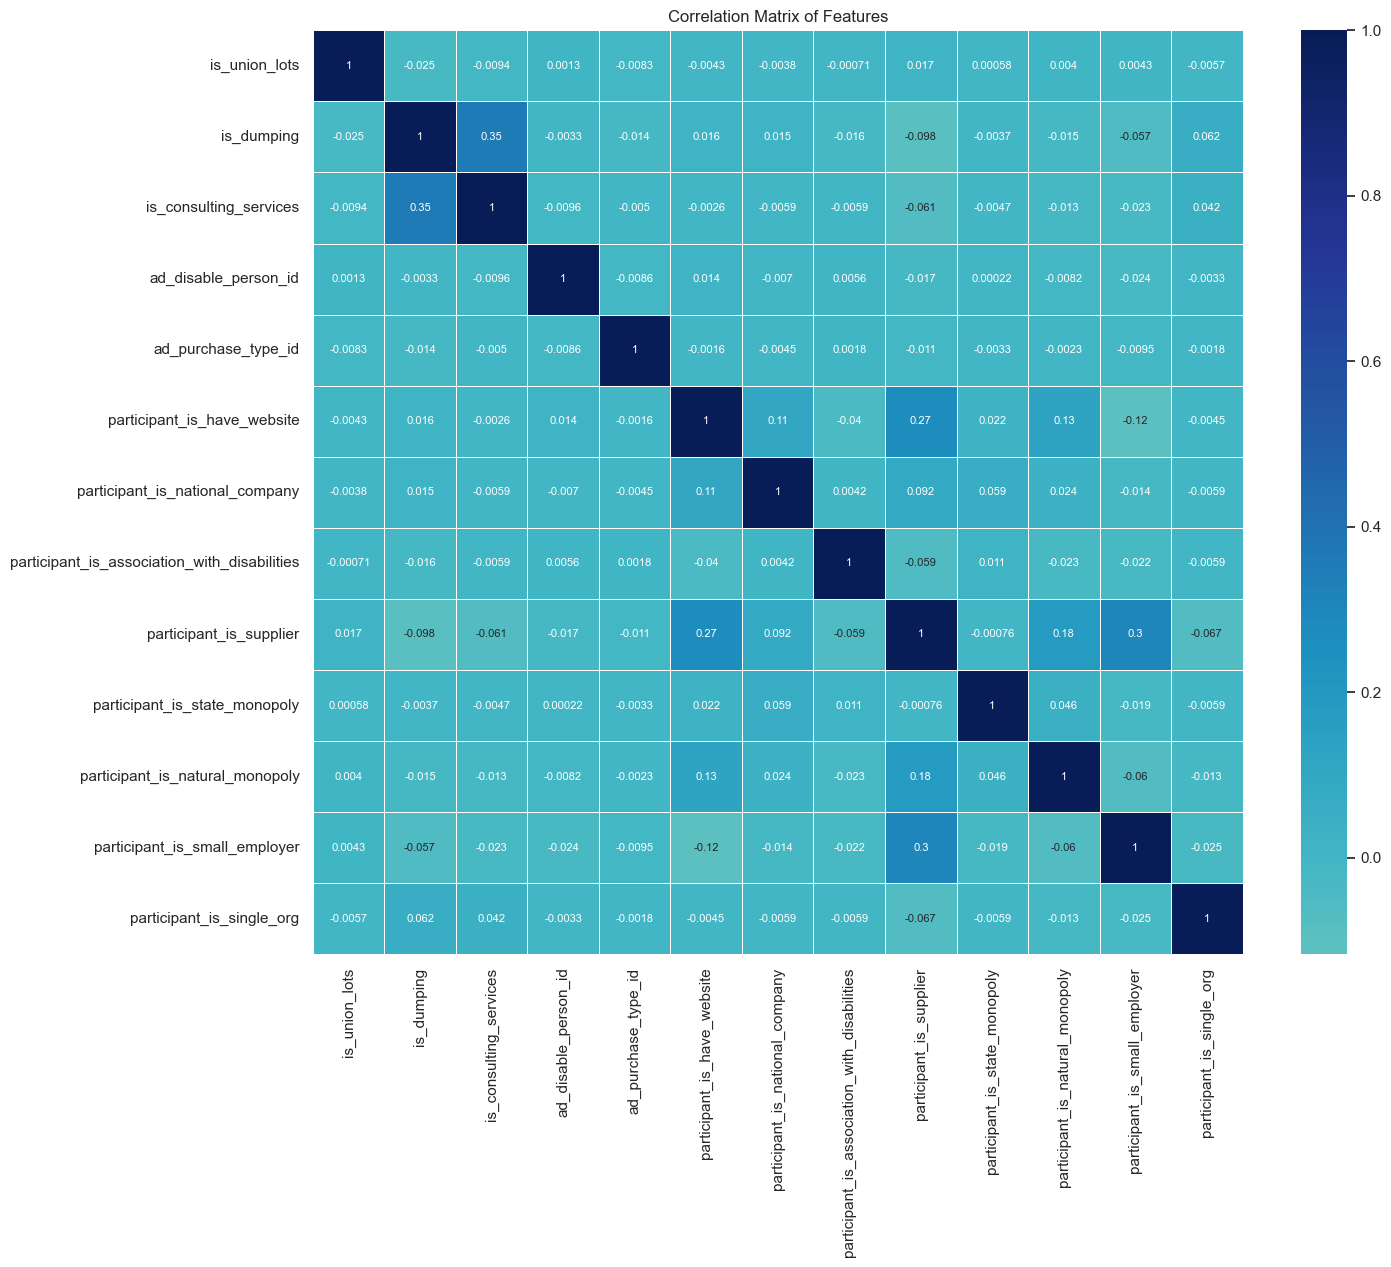

In [31]:
plt.figure(figsize=(15, 12))

sns.heatmap(
    data[group_columns].drop(columns=["participant_is_quazi"]).corr(),
    annot=True, cmap='YlGnBu', center=0, linewidths=0.5, annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Features')
plt.savefig("corr_matrix_feat.png", bbox_inches='tight')
plt.show()

## Data Engineering: select features, encoding categorical ones

In [337]:
columns_check_correlation = [i for i in group_columns if i not in ["is_disable_person_advertisement", "participant_is_quazi"]]
vif_values = [
    variance_inflation_factor(data[columns_check_correlation].dropna().values, i) 
    for i in range(data[columns_check_correlation].shape[1])
]

for var, vif in zip(columns_check_correlation, vif_values):
    print(f"{var:30s}     {vif:5.2f}")

is_union_lots                       1.01
is_dumping                          1.17
is_consulting_services              1.15
ad_disable_person_id                1.01
ad_purchase_type_id                 1.00
participant_is_have_website         1.49
participant_is_national_company      1.03
participant_is_association_with_disabilities      1.00
participant_is_supplier             1.98
participant_is_state_monopoly       1.04
participant_is_natural_monopoly      1.14
participant_is_small_employer       1.34
participant_is_single_org           1.01


In [351]:
grouped_results_categorical = []

for col in ["plan_trade_method_id", "ad_trade_method_id"]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# PlanTradeMethod
# 3 - запрос ценовых предложений
# 2 - Открытый конкурс
# 188 - Конкурс с использованием рейтингово-балльной системы
# 133 - Второй этап конкурса с использованием рамочного соглашения

,name,value,count
0,plan_trade_method_id,124,4291
1,plan_trade_method_id,126,8219
2,plan_trade_method_id,133,10629
3,plan_trade_method_id,177,76
4,plan_trade_method_id,188,14580
5,plan_trade_method_id,2,55030
6,plan_trade_method_id,3,1404694
7,plan_trade_method_id,32,8667
8,plan_trade_method_id,50,2787
9,plan_trade_method_id,52,2583


In [353]:
grouped_results_categorical = []

for col in ["ad_trade_type_id"]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# ad_trade_type_id
# 1 - Первая закупка
# 2 - Повторная закупка
# 10 - Первая закупка
# 11 - Повторная закупка
# 0 - null
# 21 - Первая закупка
# 22 - Повторная закупка
# 24 - Первая закупка
# 25 - Повторная закупка
# 3 - Первая закупка
# 30 - Первая закупка
# 32 - Первая закупка
# 33 - Повторная закупка
# 34 - Первая закупка
# 35 - Повторная закупка
# 39 - Первая закупка
# 4 - Повторная закупка
# 40 - Повторная закупка
# 42 - Первая закупка
# 44 - Повторная закупка с изменениями КД
# 5 - Первая закупка
# 52 - Первая закупка
# 53 - Повторная закупка
# 56 - Первая закупка
# 57 - Повторная закупка
# 6 - Повторная закупка
# 60 - Первая закупка
# 61 - Повторная закупка
# 65 - Первая закупка

,name,value,count
0,ad_trade_type_id,0,16
1,ad_trade_type_id,1,4557025
2,ad_trade_type_id,10,4490
3,ad_trade_type_id,11,146
4,ad_trade_type_id,2,206778
5,ad_trade_type_id,21,6243
6,ad_trade_type_id,22,1828
7,ad_trade_type_id,24,32879
8,ad_trade_type_id,25,4416
9,ad_trade_type_id,3,230953


In [359]:
data['ad_trade_type_id'] = data['ad_trade_type_id'].astype(int)

Removing 16 rows without an indication of the ad trade type.

In [366]:
data = data[data.ad_trade_type_id != 0] 

Adding a new column 'is_repeated_ad' based on a condition from above inducated ad trade type id-s.

In [369]:
repeated_purchase_ids = [2, 11, 22, 25, 33, 35, 4, 40, 44, 53, 57, 6, 61]

data['is_repeated_ad'] = np.where(data['ad_trade_type_id'].isin(repeated_purchase_ids), 1, 0)

A look-through the several of categorical feature compositions.
- **`psd_sign`**: This feature indicates work type, where 1 represents work with Feasibility Study (FS) documentation and 2 represents work for developing FS documentation. However, its values do not align with official documentation.  
- **`single_org_sign`**: This feature does not match the official documentation. It is intended to denote procurements by the Unified Organizer of the Ministry of Finance of the Republic of Kazakhstan.  
- **`is_light_industry`**: The field was not populated in the dataset.  
- **`is_construction_work`**: The data in this field did not comply with official documentation. While only values 0 and 1 are permissible, other values such as 4 were present, making interpretation impossible.  
- **`ad_subject_type_id`**: This feature categorizes the subject type of the advertisement:  
  - 1: Product  
  - 2: Work  
  - 3: Service

Leaving **`ad_subject_type_id`** as a useful feature.

In [375]:
grouped_results_categorical = []

for col in [
    # "psd_sign",
    # "single_org_sign",
    # "is_light_industry",
    # "is_construction_work",
    "ad_subject_type_id"
]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# ad_subject_type_id
# 1 - Товар, product
# 2 - Работа, work
# 3 - Услуга, service



,name,value,count
0,ad_subject_type_id,1,4031209
1,ad_subject_type_id,2,404998
2,ad_subject_type_id,3,729563


In [374]:
data['ad_subject_type_id'] = data['ad_subject_type_id'].astype(int)

In [377]:
data['is_subject_type_work'] = np.where(data['ad_subject_type_id'] == 2, 1, 0)
data['is_subject_type_service'] = np.where(data['ad_subject_type_id'] == 3, 1, 0)

Looking through the next bunch of categorical features. Converting creation creation date feature to the age of an organization.

In [396]:
grouped_results_categorical = []

# ad_is_light_industry - мало значений, не соответствует документации
# ad_is_construction_work - не соответствует документации

for col in [
    "ad_single_org_sign",
    "ad_is_light_industry",
    "ad_is_construction_work",
    "participant_creation_date",
    "participant_registration_year",
    "participant_krp_code",
    "participant_kse_code",
]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]


,name,value,count
0,ad_single_org_sign,0,5038709
1,ad_single_org_sign,1,31787
2,ad_single_org_sign,2,4936
3,ad_single_org_sign,3,90338
4,ad_is_light_industry,0,5131242
5,ad_is_light_industry,1,13940
6,ad_is_light_industry,2,18677
7,ad_is_light_industry,3,1
8,ad_is_light_industry,4,601
9,ad_is_light_industry,5,1076


In [412]:
data['participant_creation_date'] = data['participant_creation_date'].astype(int)
data['participant_registration_year'] = data['participant_registration_year'].astype(int)

In [413]:
data['participant_creation_age'] = 2024 - data['participant_creation_date']
data['participant_registration_age'] = 2024 - data['participant_registration_year']

Looking through distributions of KRP, KSE and OKED codes of organizations (bid organizers). 

In [414]:
data['participant_krp_code'] = data['participant_krp_code'].astype(int)

In [428]:
data.participant_oked_list.value_counts().quantile(quantiles)
# , data.participant_oked_list.value_counts()

# pd.DataFrame({
#     'participant_oked_list': data.participant_oked_list.value_counts().index,
#     'count': data.participant_oked_list.value_counts().values,
#     # 'quantile': pd.cut(
#     #     data.participant_oked_list.value_counts().cumsum(),
#     #     bins=[0] + list(data.participant_oked_list.value_counts().cumsum().quantile([0.25, 0.5, 0.75, 1.0])),
#     #     labels=False,
#     #     include_lowest=True
#     # )
# }).head(30)

0.00         1.00
0.01         3.00
0.05         6.85
0.10        50.80
0.25       346.00
0.50     1,236.50
0.75     9,992.25
0.90    59,006.80
0.95    96,222.70
0.99   375,069.30
1.00   691,053.00
Name: count, dtype: float64

In [440]:
for oked in data.participant_oked_list.value_counts().index[data.participant_oked_list.value_counts().values >= data.participant_oked_list.value_counts().quantile(0.9)]:
    column_name = f'is_participant_oked_{oked}'
    data[column_name] = data['participant_oked_list'].apply(lambda x: 1 if x == oked else 0)

In [441]:
data[[f'is_participant_oked_{oked}' for oked in data.participant_oked_list.value_counts().index[data.participant_oked_list.value_counts().values >= data.participant_oked_list.value_counts().quantile(0.9)]]].head()

,is_participant_oked_85310,is_participant_oked_86101,is_participant_oked_85100,is_participant_oked_84120,is_participant_oked_84114,is_participant_oked_84113,is_participant_oked_85322,is_participant_oked_84130,is_participant_oked_85421,is_participant_oked_87200,...,is_participant_oked_84220,is_participant_oked_87300,is_participant_oked_84230,is_participant_oked_91012,is_participant_oked_86210,is_participant_oked_93299,is_participant_oked_85599,is_participant_oked_84112,is_participant_oked_84250,is_participant_oked_85321
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [443]:
data.participant_kse_code.value_counts()

participant_kse_code
5    4970150
6     110780
2      78031
7       4721
1       1545
9        196
8        187
4        136
3         24
Name: count, dtype: int64

In [444]:
kse_codes = [5, 6, 2]

for code in kse_codes:
    column_name = f'is_participant_kse_code_{code}'
    data[column_name] = data['participant_kse_code'].apply(lambda x: 1 if x == code else 0)

Converting ad duration to categorical feature. Distributing to three categories by their interval.

In [451]:
data['ad_start_date'] = pd.to_datetime(data['ad_start_date'])
data['ad_repeat_start_date'] = pd.to_datetime(data['ad_repeat_start_date'])
data['ad_end_date'] = pd.to_datetime(data['ad_end_date'])
data['ad_repeat_end_date'] = pd.to_datetime(data['ad_repeat_end_date'])

In [462]:
data['f_ad_start_date'] = data['ad_start_date'].combine_first(data['ad_repeat_start_date'])
data['f_ad_end_date'] = data['ad_repeat_end_date'].combine_first(data['ad_end_date'])

In [475]:
data["ad_duration"] = (data['f_ad_end_date'] - data['f_ad_start_date']).dt.days

In [479]:
data = data[~(data.f_ad_end_date < data.f_ad_start_date)] # некорректно заполненные на портале

In [499]:
data["ad_duration"].quantile([0.0, 0.25, 0.5, 0.75, 0.78, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999, 1.0])

0.00    0.00
0.25    7.00
0.50    7.00
0.75    7.00
0.78    8.00
0.80    8.00
0.90   10.00
0.95   15.00
0.99   33.00
1.00   40.00
1.00   54.00
1.00   69.00
1.00   90.00
Name: ad_duration, dtype: float64

In [ ]:
data = data[data.ad_duration <= 90]

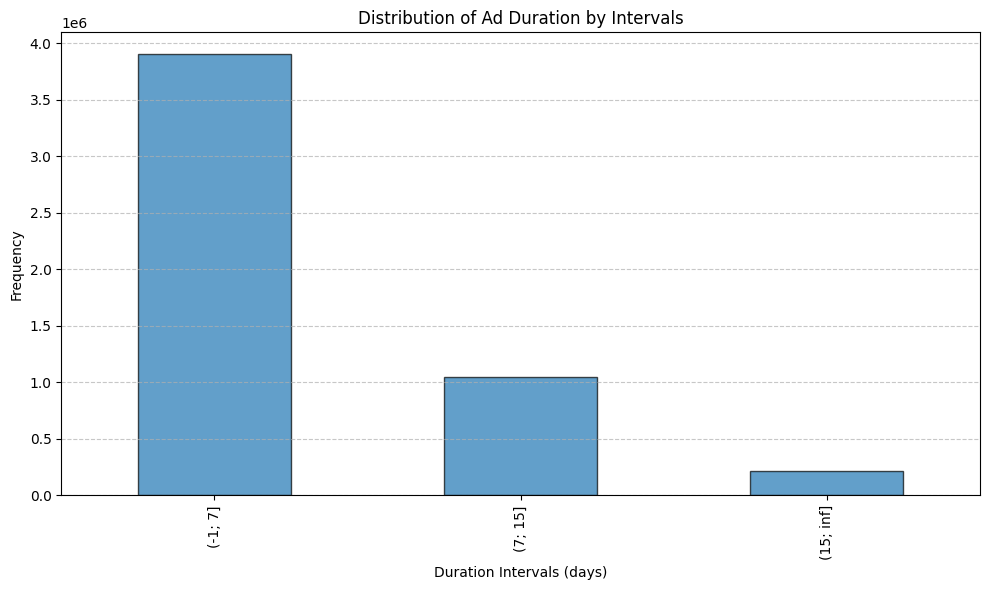

In [507]:
bins = [-1, 7, 15, float('inf')]
labels = ['(-1; 7]', '(7; 15]', '(15; inf]']

plt.figure(figsize=(10, 6))
pd.cut(data['ad_duration'], bins=bins, labels=labels, include_lowest=True).value_counts(sort=False).plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Distribution of Ad Duration by Intervals")
plt.xlabel("Duration Intervals (days)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [541]:
data['ad_duration_power'] = pd.cut(
    data['ad_duration'],
    bins=[-1, 7, 15, float('inf')],
    labels=[0, 1, 2]
).astype(int)

Add a feature indicative if an ad is covering multiple financial years.

In [534]:
data['is_multi_year'] = (data.ad_fin_years.apply(lambda x: x.split(":")).apply(lambda x: len(x)) > 1).astype(int)

Converting descriptive features **`participant_kopf_code`**, **`participant_branches`**, **`participant_parent_company`** to binary classification features **`is_participant_kopf_УЧР`**, **`has_participant_branches`**, **`has_participant_parent_company`**

In [ ]:
        # "ad_katos",
        # "participant_kato_list",
        # "participant_kopf_code",
        # "participant_branches",
        # "participant_parent_company",

In [536]:
data.participant_kopf_code.value_counts()

participant_kopf_code
ГУ     2729854
ГП     1801365
АО      308980
ТОО     169983
УЧР        600
Name: count, dtype: int64

In [544]:
data = pd.concat(
    [
        data,
        pd.get_dummies(data['participant_kopf_code'], prefix='is_participant_kopf').astype(int).drop(columns=['is_participant_kopf_УЧР'])
    ],
    axis=1
)

In [563]:
data['has_participant_branches'] = data['participant_branches'].apply(
    lambda x: [] if pd.isna(x) else x.split(":")
).apply(lambda x: len(x) > 0).astype(int)

In [570]:
data["has_participant_parent_company"] = data['participant_parent_company'].apply(
    lambda x: [] if pd.isna(x) else x.split(":")
).apply(lambda x: len(x) > 0).astype(int)

<br/>
<br/>

# 2. Model training

In [ ]:
Defing a function, which would penalize overprice predictions.

In [633]:
def overprice_watchdog(y_true, y_pred):
    alpha = 0.0

    residual = y_pred - y_true
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = 2 * np.ones_like(residual)

    return gradient, hessian
    # residual = y_pred - y_true
    # grad = 2 * residual
    # hess = 2 * np.ones_like(residual)

    # grad[residual > 0] *= 1.5
    # return grad, hess


In [925]:
# np.log2(data["sw_total_price_wdiscount"].quantile(quantiles))

0.00   10.50
0.01   11.07
0.05   11.97
0.10   12.71
0.25   14.11
0.50   15.94
0.75   18.07
0.90   20.33
0.95   21.84
0.99   24.84
1.00   35.51
Name: sw_total_price_wdiscount, dtype: float64

Looking through the correlation matrix of columns, deciding on final dataset features.

In [936]:
columns_to_take = [
    "total_amount",
    # "has_participant_branches",
    # "is_multi_year",
    # "has_participant_parent_company",
    # "ad_duration_power",
    # # "is_participant_kopf_ГУ",
    # "is_participant_kopf_ГП",
    # # "is_participant_kopf_АО",
    # "is_participant_kopf_ТОО",
    # # "is_participant_kse_code_2",
    # # "is_participant_kse_code_5",
    # # "is_participant_kse_code_6",
    # "participant_krp_code",
    # "participant_registration_age",
    # "participant_creation_age",
    
    # "is_subject_type_work",
    # "is_subject_type_service",
    # "total_count"
] 
# + list(data.filter(like="is_participant_oked_").columns)

X = data[np.log2(data["sw_total_price_wdiscount"]) <= 24.84][columns_to_take].copy()
X['total_amount'] = np.log2(X['total_amount'] + 1)


y = data[np.log2(data["sw_total_price_wdiscount"]) <= 24.84]["sw_total_price_wdiscount"] - 1
y = np.log2(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

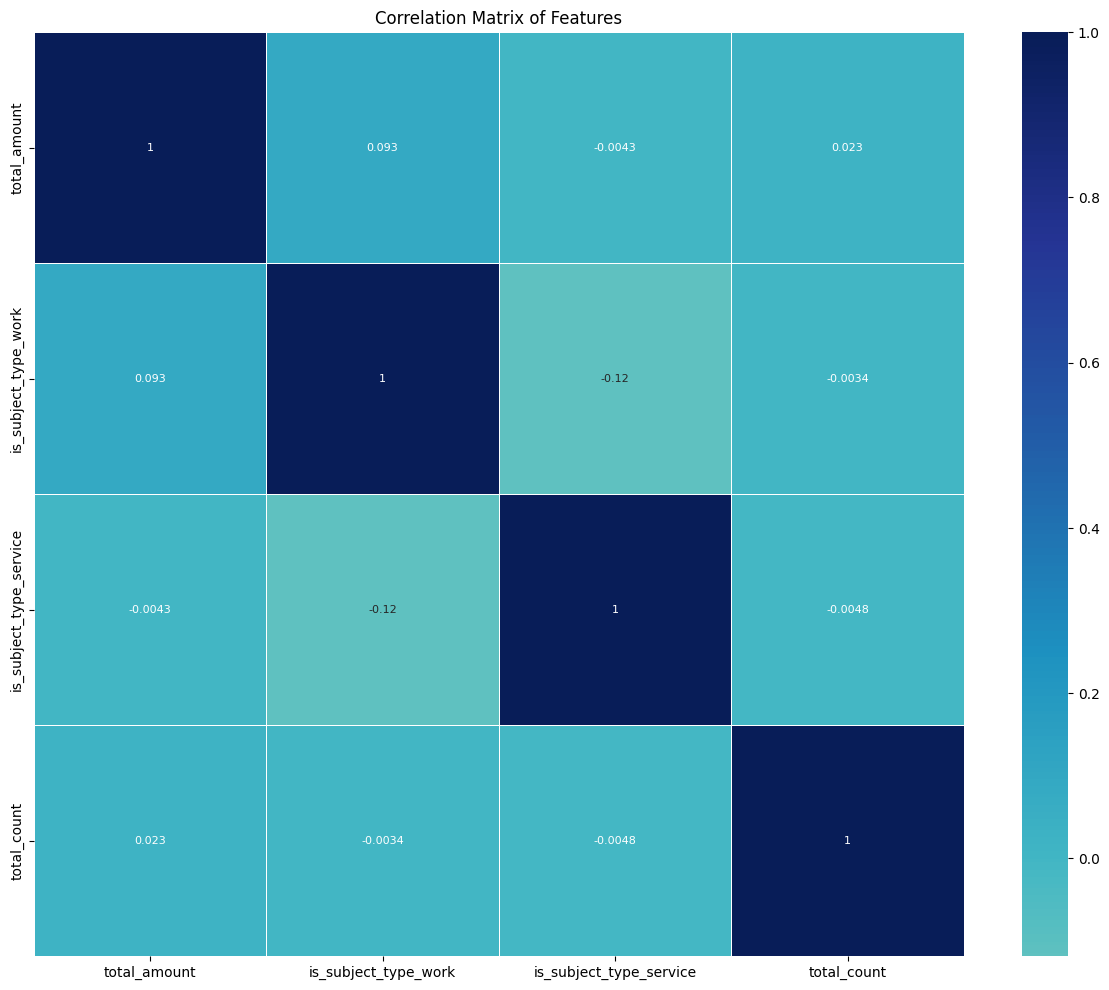

In [927]:
plt.figure(figsize=(15, 12))

sns.heatmap(
    data[columns_to_take].corr(),
    annot=True, cmap='YlGnBu', center=0, linewidths=0.5, annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
Applying linear regression.

In [928]:
import statsmodels.api as sm

X_train_with_intercept = sm.add_constant(X_train)

# Fit the regression model using statsmodels
model = sm.OLS(y_train, X_train_with_intercept).fit()

# Get the summary table
summary_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(X_train.columns),
    "Coefficient": model.params.values,
    "P-Value": model.pvalues.values,
    "Standard Error": model.bse.values
})

# Add Absolute Contribution column for interpretability
summary_df["Absolute Contribution"] = abs(summary_df["Coefficient"])

# Sort by absolute contribution
summary_df = summary_df.sort_values(by="Absolute Contribution", ascending=False).reset_index(drop=True)


y_pred = model.predict(sm.add_constant(X_test))

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

summary_df


# linreg = LinearRegression()
# linreg.fit(X_train, y_train)

# # Predict on the test set
# y_pred = linreg.predict(X_test)

# # Evaluate performance
# mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
# r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

# mse, r2, np.sqrt(mse), mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

,Feature,Coefficient,P-Value,Standard Error,Absolute Contribution
0,total_amount,0.98,0.00,0.00,0.98
1,Intercept,-0.08,0.00,0.00,0.08
2,is_subject_type_work,0.03,0.00,0.00,0.03
3,is_subject_type_service,-0.01,0.00,0.00,0.01
4,total_count,0.00,0.00,0.00,0.00


In [921]:
import pickle

In [922]:
with open("linear_regression_model_v1.pkl", "wb") as file:
    pickle.dump(model, file)

In [930]:
mse, r2, np.sqrt(mse), mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

(294864800382.4598,
 0.9464858865641749,
 np.float64(543014.5489602095),
 128170.42602990188)

In [929]:
# MSE: 5033015827510304.0, R2 Score: 0.4112988377639333; test-rmse:0.40979	test-custom_rmse:0.40979
(y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100

(np.int64(397674), np.float64(38.87969871885119))

In [ ]:
Applying XGBoost.

[0]	train-rmse:15.14960	train-custom_rmse:229.51060	test-rmse:15.15253	test-custom_rmse:229.59901
[1]	train-rmse:14.39258	train-custom_rmse:207.14633	test-rmse:14.39539	test-custom_rmse:207.22719
[2]	train-rmse:13.67343	train-custom_rmse:186.96268	test-rmse:13.67612	test-custom_rmse:187.03644
[3]	train-rmse:12.99026	train-custom_rmse:168.74689	test-rmse:12.99285	test-custom_rmse:168.81416
[4]	train-rmse:12.34128	train-custom_rmse:152.30707	test-rmse:12.34376	test-custom_rmse:152.36847
[5]	train-rmse:11.72476	train-custom_rmse:137.47018	test-rmse:11.72715	test-custom_rmse:137.52603
[6]	train-rmse:11.13911	train-custom_rmse:124.07966	test-rmse:11.14141	test-custom_rmse:124.13093
[7]	train-rmse:10.58276	train-custom_rmse:111.99489	test-rmse:10.58497	test-custom_rmse:112.04162
[8]	train-rmse:10.05426	train-custom_rmse:101.08809	test-rmse:10.05639	test-custom_rmse:101.13090
[9]	train-rmse:9.55222	train-custom_rmse:91.24493	test-rmse:9.55427	test-custom_rmse:91.28405
[10]	train-rmse:9.07532	

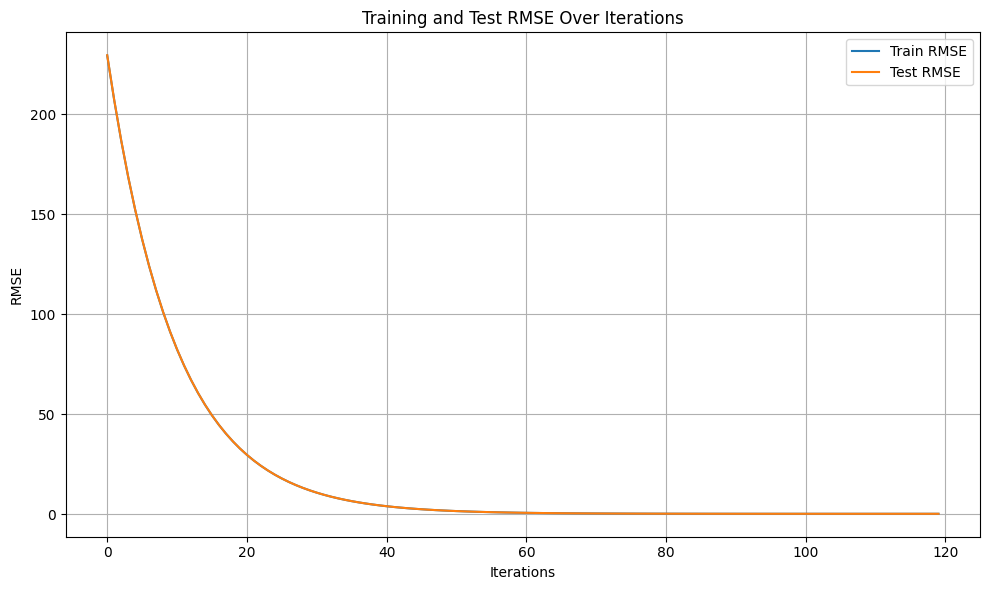

In [939]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


def overprice_watchdog(y_pred, dtrain):
    y_true = dtrain.get_label()
    residual = y_pred - y_true

    alpha = 0.4
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = np.where(residual > 0, 2 * alpha, 2 * (1 - alpha))
    # hessian = 2 * np.ones_like(residual)

    return gradient, hessian


def custom_rmse(y_pred, dtrain):
    y_true = dtrain.get_label()
    # y_pred = np.power(2, y_pred) + 1
    # y_true = np.power(2, y_true) + 1
    
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return "custom_rmse", rmse ** 2


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evals_result = {}


params = {
    "learning_rate": 0.05,
    # "max_depth": 7,
    "random_state": 42,
    "reg_alpha": 1
    # "n_estimators": 100
}

evals = [(dtrain, "train"), (dtest, "test")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=120,
    obj=overprice_watchdog,
    custom_metric=custom_rmse,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=True
)

y_pred = model.predict(dtest)

mse = mean_squared_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
r2 = r2_score(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)
print(f"MSE: {mse}, R2 Score: {r2}")


plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['custom_rmse'], label='Train RMSE')
plt.plot(evals_result['test']['custom_rmse'], label='Test RMSE',)
plt.title("Training and Test RMSE Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [940]:
# (np.int64(358119), np.float64(35.012494720540616), 123810.45023454943)
(y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100, mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

(np.int64(417007), np.float64(40.76984294586013), 115367.56655212573)

In [941]:
model.save_model("xgb_model.json")

In [962]:
def choose_best_arm(predictions, true_value):
    valid_predictions = [pred for pred in predictions if pred <= true_value]

    if valid_predictions:
        # Find the closest valid prediction to the true_value
        closest_prediction = max(valid_predictions)  # Closest lower value
    else:
        # If no predictions are valid, pick the lowest prediction
        closest_prediction = min(predictions)

    # Return the index of the closest prediction
    return predictions.index(closest_prediction)



n_arms = 4  # Number of pricing strategies
pricing_strategies = [0.90, 0.95, 1.0, 1.05]
successes = [0] * n_arms
failures = [0] * n_arms

results = []
for i in range(len(X_test)):
    if i % 10 == 0:
        print(i)
    if i == 100_000:
        break

    single_row = X_test.iloc[i:i + 1]
    dmatrix_input = xgb.DMatrix(single_row)

    base_prediction = model.predict(dmatrix_input)[0]

    # Adjust predictions using all strategies
    adjusted_predictions = [base_prediction * multiplier for multiplier in pricing_strategies]

    # True value for comparison
    true_value = y_test.iloc[i]

    # Choose the best arm
    chosen_arm = choose_best_arm(adjusted_predictions, true_value)

    # Final adjusted prediction using the chosen arm
    adjusted_prediction = adjusted_predictions[chosen_arm]

    # Determine if the chosen prediction is rewarded
    reward = 1 if adjusted_prediction <= true_value else 0

    if reward:
        successes[chosen_arm] += 1
    else:
        failures[chosen_arm] += 1
    
    # Log results
    results.append({
        "true_value": true_value,
        "base_prediction": base_prediction,
        "adjusted_prediction": adjusted_prediction,
        "chosen_arm": chosen_arm,
        "reward": reward
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
print(results_df.head())


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [975]:
def thompson_sampling_bandit(n_arms, successes, failures):
    sampled_values = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(n_arms)]
    return np.argmax(sampled_values)

thompson_sampling_bandit(4, successes, failures), successes, failures
# choose_best_arm([168_651.94])

(np.int64(1), [3993, 36798, 59183, 6], [20, 0, 0, 0])

In [981]:
results_df

,true_value,base_prediction,adjusted_prediction,chosen_arm,reward
0,16.84,16.72,16.72,2,1
1,11.34,11.62,11.04,1,1
2,12.45,12.36,12.36,2,1
3,16.04,15.72,15.72,2,1
4,21.33,21.35,20.28,1,1
...,...,...,...,...,...
99995,13.77,13.52,13.52,2,1
99996,17.80,18.02,17.12,1,1
99997,16.19,16.00,16.00,2,1
99998,16.12,16.30,15.49,1,1


In [982]:
(results_df.adjusted_prediction > results_df.true_value).sum()

# (y_pred > y_test).sum(), ((y_pred > y_test).sum() / len(y_test)) * 100, mean_absolute_error(np.power(2, y_test) + 1, np.power(2, y_pred) + 1)

np.int64(20)

In [945]:
# def thompson_sampling_bandit(n_arms, successes, failures):
#     sampled_values = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(n_arms)]
#     return np.argmax(sampled_values)

# # Initialize Bandit Parameters
# n_arms = 3  # Number of pricing strategies
# successes = [0] * n_arms
# failures = [0] * n_arms
# pricing_strategies = [0.9, 1.0, 1.1]

# # Simulate predictions and rewards
# results = []
# for i in range(len(X_test)):
    # if i % 10 == 0:
    #     print(i)
    # if i == 100_000:
    #     break
#     single_row = X_test.iloc[i:i + 1]
#     dmatrix_input = xgb.DMatrix(single_row)
#     base_prediction = model.predict(dmatrix_input)[0]

#     # Select the best arm using Thompson Sampling
#     chosen_arm = thompson_sampling_bandit(n_arms, successes, failures)

#     # Adjust prediction using chosen arm
#     adjusted_prediction = base_prediction * pricing_strategies[chosen_arm]

#     # Simulate reward (e.g., profit, user feedback)
#     true_value = y_test.iloc[i]  # True value for comparison
#     reward = 1 if adjusted_prediction <= true_value else 0  # Example reward logic

#     # Update successes or failures for the chosen arm
#     if reward:
#         successes[chosen_arm] += 1
#     else:
#         failures[chosen_arm] += 1

#     # Log results
#     results.append({
#         "true_value": true_value,
#         "base_prediction": base_prediction,
#         "adjusted_prediction": adjusted_prediction,
#         "chosen_arm": chosen_arm,
#         "reward": reward
#     })

# # Analyze Bandit Results
# print("Successes:", successes)
# print("Failures:", failures)
# results_df = pd.DataFrame(results)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [955]:
# results_df

thompson_sampling_bandit(n_arms, successes, failures), successes, failures

(np.int64(0), [99978, 0, 0], [20, 1, 1])

In [ ]:

def custom_mape(y_pred, dtrain):
    y_true = dtrain.get_label()
    
    # Reverse the log2 transformation for both y_pred and y_true
    y_pred_original = np.power(2, y_pred) + 1
    y_true_original = np.power(2, y_true) + 1

    # Calculate MAPE
    mape = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100
    
    return "custom_mape", mape


In [268]:
# data.groupby('is_union_lots').size().reset_index(name="count")

# # data[
# #     [
# #         "total_count",
# #         "total_amount",
# #         "ad_lots_count"
# #     ]
# # ].corr()
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='total_count', y='total_amount', data=data, alpha=0.5)
# plt.title('Relationship Between total_count and Target Variable')
# plt.xlabel('total_count')
# plt.ylabel('Target Variable')
# plt.show()


# #         # "total_count",        
# #         # "ad_lots_count",
# # # data[data.total_count > data.total_count.quantile(0.99)]
# # # data.total_count.quantile(quantiles)

# # plt.figure(figsize=(10, 6))
# # plt.hist(np.log1p(data[data.total_count <= data.total_count.quantile(0.99)]['total_count']+1), bins=100, edgecolor='black', alpha=0.7)
# # plt.title('Distribution of total_count')
# # plt.xlabel('Total Count')
# # plt.ylabel('Frequency')
# # plt.grid(axis='y', linestyle='--', alpha=0.7)
# # plt.show()

,is_union_lots,count
0,0,5087738
1,1,82415


In [451]:
# data.participant_kse_code.value_counts()

In [450]:
# data[data.fw_total_price_wdiscount == data.total_amount].participant_kse_code.value_counts()

In [452]:
# data[data.fw_total_price_wdiscount == data.total_amount].ad_subject_type_id.value_counts(), data.ad_subject_type_id.value_counts()

In [454]:
# (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)

In [427]:
# data[data.unearned_revenue_pct > 4000]
# # unearned_revenue_pct

In [68]:
# data.sw_total_price_wdiscount - data.fw_total_price_wdiscount

In [343]:
X = data[
    [
        "total_amount"
    ]
].rename(
    columns={
        "total_amount": "initial_lot_price",
    }
)
# .reset_index(drop=True)

y = data["sw_total_price_wdiscount"]

X["initial_lot_price"] = np.log2(X["initial_lot_price"] + 1)
# X["advertisement_total_price"] = np.log2(X["advertisement_total_price"] + 1)
y = np.log2(y + 1)



In [107]:
# data['participant_is_small_employer'].value_counts() # возможно стоит исключить те у кого ad_fin_years == '0'

In [346]:
# xgb_model = xgb.XGBRegressor(
#     # learning_rate=0.1,
#     # max_depth=7,
#     # objective='reg:squarederror',
#     # random_state=42,
#     learning_rate=0.05,
#     max_depth=3,
#     n_estimators=100,
#     reg_lambda=1.0,  # L2 regularization
#     reg_alpha=0.5,   # L1 regularization
#     random_state=42
# )
# xgb_model.fit(X_train, y_train)

xgb_model = LinearRegression()
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2, np.sqrt(mse), mean_absolute_error(y_test, y_pred)

# (0.01799905104726207,
 # 0.979990650697431,
 # np.float64(0.13416054206532588),
 # 0.09223476723484725)

(0.18712031638672544,
 0.9811494578645338,
 np.float64(0.4325740588462575),
 0.30532992669210124)

In [347]:
y_pred_actual = (2 ** y_pred) - 1
y_test_actual = (2 ** y_test) - 1

mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mse_actual)
r2_actual = r2_score(y_test_actual, y_pred_actual)

mse_actual, r2_actual, rmse_actual, mae_actual, 

(458457218892258.9,
 0.9240833450522461,
 np.float64(21411614.1122583),
 686678.0931582405)

In [322]:
# # np.power(10, y.median()) - 1
# np.log2(data.sw_total_price_wdiscount + 1).quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])
# # y_test.quantile(0.99)

0.00     0.014355
0.01     9.967226
0.05    11.551218
0.10    12.399011
0.25    13.945901
0.50    15.861111
0.75    18.015638
0.90    20.291091
0.95    21.826872
0.99    24.757086
1.00    35.511469
Name: sw_total_price_wdiscount, dtype: float64

In [348]:
y_pred = np.power(2, xgb_model.predict(X_test)) - 1
y_test_actual = np.power(2, y_test) - 1

mae = mean_absolute_error(y_test_actual, y_pred)
over_predictions = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Output metrics
print(f"MAE: {mae}")
print(f"Percentage of Over-Predictions: {over_predictions}%")

MAE: 686678.0931582405
Percentage of Over-Predictions: 37.601587175678205%


In [334]:
data[np.log2(data.sw_total_price_wdiscount + 1) < 24.8].total_amount.median()

np.float64(70.0)

In [337]:
np.log2(data.sw_total_price_wdiscount + 1).quantile([0.99, 1.0])

0.99    24.757086
1.00    35.511469
Name: sw_total_price_wdiscount, dtype: float64

In [302]:
np.log2(X["advertisement_total_price"] + 1).quantile()

1          2.677137
2          2.677608
3          2.500298
4          2.662432
5          2.453422
             ...   
6034216    2.794420
6034217    2.321941
6034218    2.535029
6034219    2.759011
6034220    2.865926
Name: advertisement_total_price, Length: 5269412, dtype: float64

In [349]:
# X = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)][['fw_total_price_wdiscount']]
# y = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)]['sw_total_price_wdiscount']

# X['fw_total_price_wdiscount'] = np.log10(X['fw_total_price_wdiscount'] + 1)
# y = np.log10(y + 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mae = mean_absolute_error(np.power(2, y_test) - 1, (np.power(2, y_pred) - 1))
over_predictions = np.sum(y_pred > y_test) / len(y_test) * 100

{
    "MAE": mae,
    "Percentage of Over-Predictions": over_predictions,
    "Example Predictions": list(zip(y_test[:10], y_pred[:10]))
}

{'MAE': 686678.0931582405,
 'Percentage of Over-Predictions': np.float64(37.601587175678205),
 'Example Predictions': [(15.25122349523062, np.float64(15.408058092807513)),
  (14.55078285230843, np.float64(15.214461625477368)),
  (13.358239100426132, np.float64(13.381796090988713)),
  (21.089998580102538, np.float64(20.674796995127295)),
  (18.620871308634023, np.float64(18.28270353369843)),
  (16.439587428127545, np.float64(17.082843172871446)),
  (18.096300278844325, np.float64(17.72658033713662)),
  (20.437460515036197, np.float64(20.674796995127295)),
  (17.39205742710167, np.float64(17.379555865149108)),
  (16.287730413124752, np.float64(15.940919933912603))]}

In [351]:
from sklearn.tree import DecisionTreeRegressor

# X = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)][['fw_total_price_wdiscount']]
# X['fw_total_price_wdiscount'] = np.log10(X['fw_total_price_wdiscount'] + 1)

# y = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)]['sw_total_price_wdiscount']
# y_transformed = np.log10(y + 1)

# Train-test split remains the same, reuse X_train, X_test
# X_train, X_test, y_train_transformed, y_test_transformed = train_test_split(
#     X, y_transformed, test_size=0.4, random_state=42
# )

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_transformed = tree_model.predict(X_test)

# Reverse the log10 transformation
y_pred = np.power(2, y_pred_transformed) - 1
y_test_actual = np.power(2, y_test) - 1

# Evaluate the Decision Tree model
mae_tree = mean_absolute_error(y_test_actual, y_pred)
over_predictions_tree = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Display results
{
    "MAE": mae_tree,
    "Percentage of Over-Predictions": over_predictions_tree,
    "Example Predictions": list(zip(y_test_actual[:10], y_pred[:10]))
}


{'MAE': 1432362.1586402645,
 'Percentage of Over-Predictions': np.float64(40.60395243520775),
 'Example Predictions': [(39000.0, np.float64(43474.91108556567)),
  (23999.599999999988, np.float64(35410.88467347889)),
  (10500.000000000005, np.float64(11775.43063283814)),
  (2232142.859999998, np.float64(1419668.3113071886)),
  (403124.9999999998, np.float64(357991.82150277914)),
  (88880.0, np.float64(144759.23250309305)),
  (280238.40000000014, np.float64(195579.2687896759)),
  (1419999.9999999998, np.float64(1419668.3113071886)),
  (172000.00000000015, np.float64(144759.23250309305)),
  (80000.00000000006, np.float64(54510.058062247175))]}

In [354]:
import xgboost as xgb
import numpy as np

def custom_asymmetric_loss(y_true, y_pred):
    alpha = 0.2  # Penalize over-predictions more
    residual = y_pred - y_true  # Difference between predicted and true values
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = np.where(residual > 0, 2 * alpha, 2 * (1 - alpha))
    return gradient, hessian

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {"max_depth": 5, "eta": 0.05}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    obj=lambda y_pred, dtrain: custom_asymmetric_loss(dtrain.get_label(), y_pred),
    evals=[(dtest, "test")],
)


[0]	test-rmse:15.16092
[1]	test-rmse:14.40355
[2]	test-rmse:13.68406
[3]	test-rmse:13.00057
[4]	test-rmse:12.35131
[5]	test-rmse:11.73454
[6]	test-rmse:11.14864
[7]	test-rmse:10.59209
[8]	test-rmse:10.06342
[9]	test-rmse:9.56122
[10]	test-rmse:9.08418
[11]	test-rmse:8.63105
[12]	test-rmse:8.20063
[13]	test-rmse:7.79180
[14]	test-rmse:7.40347
[15]	test-rmse:7.03462
[16]	test-rmse:6.68428
[17]	test-rmse:6.35152
[18]	test-rmse:6.03550
[19]	test-rmse:5.73535
[20]	test-rmse:5.45030
[21]	test-rmse:5.17959
[22]	test-rmse:4.92251
[23]	test-rmse:4.67839
[24]	test-rmse:4.44657
[25]	test-rmse:4.22646
[26]	test-rmse:4.01747
[27]	test-rmse:3.81905
[28]	test-rmse:3.63068
[29]	test-rmse:3.45187
[30]	test-rmse:3.28215
[31]	test-rmse:3.12105
[32]	test-rmse:2.96817
[33]	test-rmse:2.82309
[34]	test-rmse:2.68544
[35]	test-rmse:2.55484
[36]	test-rmse:2.43096
[37]	test-rmse:2.31347
[38]	test-rmse:2.20205
[39]	test-rmse:2.09642
[40]	test-rmse:1.99627
[41]	test-rmse:1.90136
[42]	test-rmse:1.81142
[43]	test-rm

In [356]:
# Make predictions
y_pred_transformed = model.predict(dtest)
y_pred = np.power(2, y_pred_transformed) - 1
y_test_actual = np.power(2, y_test) - 1

# Evaluate results
mae = mean_absolute_error(y_test_actual, y_pred)
over_predictions = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Output metrics
print(f"MAE: {mae}")
print(f"Percentage of Over-Predictions: {over_predictions}%")


MAE: 1826068.8810439194
Percentage of Over-Predictions: 40.753764224007384%


In [39]:
data[(data.sw_total_price_wdiscount == 0) & (data.sw_total_price_wdiscount != data.fw_total_price_wdiscount)]

,advertisement_id,lot_id,fw_item_price,fw_total_price,fw_discount,fw_total_price_wdiscount,sw_item_price,sw_total_price,sw_discount,sw_total_price_wdiscount,...,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_world_company,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_patronymic_producer,participant_is_patronymic_supplier,participant_is_small_employer,participant_is_single_org
